# Analysis of noodel data

A quick exploratory analysis of nodel dataset obtained from Victor. 

## Import modules and define functions

In [4]:
%matplotlib inline
import scipy
import pynbody as pb
from scipy import stats as st
from matplotlib.colors import LogNorm
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

# model_dir = 'run732HF/'
model_dir = 'new_models/'
base_dir = '/home/ubuntu/projects/S2B/models/' + model_dir
image_dir = '/home/ubuntu/projects/S2B/code/images/' + model_dir
# param_fname = base_dir + 'run732HF.param'

def pbload(filename, paramname=None):
    print('Loading data from file', filename, '...')
    if '::' in filename:
        filename, species = filename.split('::')
        sim = pb.load(filename, paramname=paramname)
        sim = getattr(sim, species)
    else:
        sim = pb.load(filename, paramname=paramname)
    print('Done!')
    return sim

def Gauss_Hermite(w, n):
    """
    Return the Gauss Hermite function of order n, weights w
    Gerhard MNRAS (1993) 265, 213-230
    Equations 3.1 - 3.7
    @author: Steven Gough-Kelly
    """
    w = np.array(w)
    p = scipy.special.hermite(n, monic=False) #hermite poly1d obj
    norm = np.sqrt((2**(n+1))*np.pi*np.math.factorial(n)) # N_n Eqn 3.1
    return (p(w)/norm) * np.exp( -0.5 * w * w )

def GaussHermiteMoment(v, n):
    v = v[np.isfinite(v)] # remove nans&inf
    if len(v) <= 1: # Added SL speed+error catch
        return np.nan
    v_dash = (v - np.mean(v))/np.std(v) # center on 0, norm width to 1sig
    hn = np.sum(Gauss_Hermite(v_dash, n))
    return np.sqrt(4*np.pi) * hn / len(v)

def bar_align(galaxy, rbar, barfrac = 0.5, zlim=0.5, log=False):
    """
    Aligns the bar of pynbody galaxy simulation with the x-axis assuming the
    galaxy disc is already aligned to the XY plane using the inertial tensor.

    Function does not return any values/object. Pynbody functions effect the
    global variable which stores 'galaxy' so rotations within the functions
    are applied to input variable 'galaxy'.

    Parameters
    ----------
    galaxy : pynbody simulation object
        Galaxy object in the XY plane to be aligned.

    rbar : float
        Bar radius in simulation units e.g. kpc.

    barfrac : float
        Fraction of bar length to calculate the inertial tensor within in
        simulation units e.g. kpc.

    zlim : float
        Vertical limit to calculate intertial tensor within in simulation units
        e.g. kpc. Useful in galaxies with thick discs and weak bars.

    log : Bool
        Flag to output print statements.

    Returns
    -------
    None

    """
    if np.isnan(rbar):
        if log:
            print('* Bar undefined, using 1 kpc *')
        rbar = 1.0
    elif rbar*barfrac < 1.:
        rbar = 1
        if log:
            print('* Short Bar, using 1 kpc *')
    else:
        rbar = rbar*barfrac
        if log:
            print('* Bar defined, aligning to {} kpc *'.format(rbar))

    if log:
        print('* Realigning bar using |z| < {} *'.format(zlim))

    zfilt = pb.filt.LowPass('z',zlim)&pb.filt.HighPass('z',-zlim)
    rfilt = pb.filt.LowPass('rxy',rbar)

    x = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,0]
    y = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,1]
    m = np.array(galaxy.star[zfilt&rfilt]['mass'])

    #Calculate the inertia tensor
    I_yy, I_xx, I_xy = np.sum(m*y**2),np.sum(m*x**2),np.sum(m*x*y)
    I = np.array([[I_yy, -I_xy], [-I_xy, I_xx]])

    #Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(I)
    lowest = eigenvalues.argmin()
    maj_axis = eigenvectors[:, lowest]

    #Get the angle we need to rotate by
    r_angle = np.degrees(np.arctan2(maj_axis[1], maj_axis[0]))

    galaxy.rotate_z(-r_angle)

    if log:
        print('* Bar realigned by {} degrees*'.format(r_angle))

    return None

def plot_image ():
    image = plt.imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    xcent = (xedges[1:] + xedges[:-1]) / 2
    ycent = (yedges[1:] + yedges[:-1]) / 2

    plt.title(plt_title)  
    cbar = plt.colorbar()
    cbar.set_label(cbar_label)
    axes = plt.gca()
    axes.set_aspect(1)
    # axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
    axes.set_xlabel('x [kpc]')
    axes.set_ylabel('y [kpc]')
    axes.set_xlim(-xlim, xlim)
    axes.set_ylim(-ylim, ylim)
    plt.show()

def load_data_lst():
    s_lst = []
    for snap in snap_lst:
        
        snap_name = snap.replace('.gz','')
        
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]))
        pb.analysis.angmom.faceon(s)
        bar_align(s,3.,barfrac=1.,zlim=0.5,log=True)
        s_lst.append(s)
    return(s_lst)

def load_data():
    s = pbload(data_fname,param_fname)
    pb.analysis.angmom.faceon(s)
    return(s)

def list_snaps(base_dir):
    import os
    # list to store files
    snap_lst = []
    param_lst = []
    # Iterate directory
    for path in os.listdir(base_dir):
        # check if current path is a file
        if os.path.isfile(os.path.join(base_dir, path)) and '.gz' in path:
            snap_lst.append(path)
        elif os.path.isfile(os.path.join(base_dir, path)) and '.param' in path:
            param_lst.append(path)
    return(sorted(snap_lst),sorted(param_lst))

snap_lst , param_lst = list_snaps(base_dir)
print(snap_lst)
print(param_lst)

['run761AV.02000.gz', 'run761BP.02000.gz', 'run761CK.02400.gz', 'run761CL.02400.gz']
['.run761AV.param.swp', 'run761AV.param', 'run761BP.param', 'run761CK.param', 'run761CL.param']


Load test snapshot with param file

In [3]:
data_fname = '/home/ubuntu/projects/S2B/models/new_models/run761AV.02000.gz'
param_fname = '/home/ubuntu/projects/S2B/models/new_models/run761AV.param'
s = pbload(data_fname,param_fname)
pb.analysis.angmom.faceon(s)
print(data_fname)
print(param_fname)
print(s.properties)
print(s.properties['time'].in_units('Gyr'))
print(s.physical_units())
print()

data_fname = '/home/ubuntu/projects/S2B/models/run732HF/run732HF.01220.gz'
param_fname = '/home/ubuntu/projects/S2B/models/run732HF/run732HF.param'
s = pbload(data_fname,param_fname)
pb.analysis.angmom.faceon(s)
print(data_fname)
print(param_fname)
print(s.properties)
print(s.properties['time'].in_units('Gyr'))
print(s.physical_units())


Loading data from file /home/ubuntu/projects/S2B/models/new_models/run761AV.02000.gz ...
Done!
/home/ubuntu/projects/S2B/models/new_models/run761AV.02000.gz
/home/ubuntu/projects/S2B/models/new_models/run761AV.param
{'time': Unit("9.99e+00 s kpc km**-1")}
9.76641980829801
None

Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01220.gz ...
Done!
/home/ubuntu/projects/S2B/models/run732HF/run732HF.01220.gz
/home/ubuntu/projects/S2B/models/run732HF/run732HF.param
{'time': Unit("6.09e+00 s kpc km**-1")}
5.957516083061584
None


## Load data

Loading a simulation output using the `pynbody.load()` function, which tries to automatically determine which type of code output you have:

In [5]:
s_lst = load_data_lst()

Loading data from file /home/ubuntu/projects/S2B/models/new_models/run761AV.02000.gz ...
Done!
* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by 113.04864093639446 degrees*
Loading data from file /home/ubuntu/projects/S2B/models/new_models/run761BP.02000.gz ...
Done!
* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by 112.5927788125726 degrees*
Loading data from file /home/ubuntu/projects/S2B/models/new_models/run761CK.02400.gz ...
Done!
* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by -179.74843919032725 degrees*
Loading data from file /home/ubuntu/projects/S2B/models/new_models/run761CL.02400.gz ...
Done!
* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by -160.90383323993768 degrees*


Note that the above assumes you have downloaded and unpacked the test data in the above folder.

## Data exploration

### General dataset properties

In [6]:
for s in s_lst:
    print(s)

<SimSnap "/home/ubuntu/projects/S2B/models/new_models/run761AV.02000" len=3400000>
<SimSnap "/home/ubuntu/projects/S2B/models/new_models/run761BP.02000" len=3400000>
<SimSnap "/home/ubuntu/projects/S2B/models/new_models/run761CK.02400" len=3400000>
<SimSnap "/home/ubuntu/projects/S2B/models/new_models/run761CL.02400" len=3400000>


In [7]:
for s in s_lst:
    print(len(s))

3400000
3400000
3400000
3400000


`stars`, `gas`, `dark` also available as `s`, `g`, `d`

In [8]:
for s in s_lst:
    print(len(s.star), len(s.gas), len(s.dark))

2400000 0 1000000
2400000 0 1000000
2400000 0 1000000
2400000 0 1000000


The `properties` attribute of a `SimSnap` tells us some more basic info 

In [9]:
for s in s_lst:
    print(s.properties)

{'time': Unit("9.99e+00 s kpc km**-1")}
{'time': Unit("9.99e+00 s kpc km**-1")}
{'time': Unit("1.20e+01 s kpc km**-1")}
{'time': Unit("1.20e+01 s kpc km**-1")}


In [10]:
for s in s_lst:
    print(s.properties['time'].in_units('Gyr'))

9.76641980829801
9.76641980829801
11.719703769957885
11.719703769957885


Which quantities do we have available?

In [86]:
for s in s_lst:
    print(s.keys())

['pos', 'x', 'y', 'z', 'vel', 'vx', 'vy', 'vz', 'mass', 'eps', 'phi', 'rxy']
['pos', 'x', 'y', 'z', 'vel', 'vx', 'vy', 'vz', 'mass', 'eps', 'phi', 'rxy']
['pos', 'x', 'y', 'z', 'vel', 'vx', 'vy', 'vz', 'mass', 'eps', 'phi', 'rxy']
['pos', 'x', 'y', 'z', 'vel', 'vx', 'vy', 'vz', 'mass', 'eps', 'phi', 'rxy']


None! Because pynbody "lazy-loads" data... so lets see which data is actually on-disk:

In [39]:
for s in s_lst:
    print(s.loadable_keys())

['eps', 'phi', 'mass', 'pos', 'vel']
['eps', 'phi', 'mass', 'pos', 'vel']
['eps', 'phi', 'mass', 'pos', 'vel']
['eps', 'phi', 'mass', 'pos', 'vel']


vel - velocity components vx, vy, vz - **km/s ?**, 
**phi - ?**, 
**eps - ?**, 
pos - position components x, y, z - kpc, 
mass - particle mass, **units?**

By default everything is in system units, but most of the time thinking in physical units is easier: But aparently there is no physical units defined in this dataset.

In [40]:
for s in s_lst:
    print(s.physical_units())

None
None
None
None


### Dataset components

To access any of these arrays or vectors, you access them like a python dictionary: 

In [41]:
for s in s_lst:
    print(s.star['pos'])

[[-2.06119438  5.9828408   1.19180165]
 [ 1.89358173 -0.19750955 -0.47193331]
 [-0.72801889 -0.15808815 -0.43922242]
 ...
 [-0.29203276 -0.0891722  -0.02395775]
 [-0.19128894 -0.14316616 -0.49892503]
 [ 0.29772051  0.10126607 -0.12179133]]
[[-6.91257122 -3.51793118 -1.14291445]
 [-4.94290687  5.08602673  1.88966557]
 [-7.87267861 -0.17224011  1.14808713]
 ...
 [ 0.3676804   0.22482976 -0.36690465]
 [-2.74858227  1.18721018  0.33644367]
 [ 0.36577556  0.28173129 -0.05309902]]
[[-4.4243542  -5.73179245  0.53781599]
 [-5.2646807  -3.04308547 -1.02806132]
 [-4.50156315 -3.77874896 -2.11662964]
 ...
 [-1.46555284 -0.44991262  0.64423086]
 [-0.10759888  0.13847351 -0.07821557]
 [ 0.91190751  0.35225518 -0.4698639 ]]
[[ 1.24410689 -8.73633126  0.3759821 ]
 [ 1.4869115   5.41276219  1.03511581]
 [-1.48899347  5.32740914 -0.32373456]
 ...
 [-0.32398923  0.41131352  0.08160249]
 [-0.44295801  0.08571478  0.07243831]
 [-0.1720112   0.01203301 -0.21187634]]


Note that each array has units attached...

In [42]:
for s in s_lst:
    print(s.star['vel'])

[[-49214.66801233  -2043.67187153 -14227.11835968]
 [-23029.05930138  11865.35772032   6389.83477218]
 [-65935.45740938 -37488.19974647 -55679.72244722]
 ...
 [ 12376.50832938  32030.16699771  -7033.96991447]
 [-19044.22816301  13871.28694576  -7668.80728753]
 [-21318.64849689 -10153.47962197 -24026.36846491]]
[[ 27692.27439398 -37346.53737342   -680.19519443]
 [-31631.66693948 -26119.63079802  21535.21025109]
 [ -8652.60836201 -51817.0972959  -23975.5626806 ]
 ...
 [ -9891.7142593   21924.3311783   22028.14325817]
 [-10120.10487695 -13538.45544075 -24297.02412085]
 [ 27608.03730836  10430.9391875   -7977.84443802]]
[[ 56659.85290629 -34857.01308586  -3714.37616432]
 [ 22836.56462942 -63743.40184587  11348.22046328]
 [ 31351.12967227 -38566.9510563   14013.20441949]
 ...
 [ 38789.97426795  -7547.638012   -41634.71602162]
 [ -5191.06977939  46001.31134813  -4045.64673744]
 [-26581.98723536   7764.35502867 -35366.42252214]]
[[ 57897.8257275   11628.15533582  -1174.54157614]
 [-56539.3091

We can look at stellar age.

In [11]:
import numpy.ma as ma

i = 0
for s in s_lst:
    total = 0
    max_age = round(max(s.star['age']),2)
    print('Snap ' + snap_lst[i].replace('.gz','') + ' max age - ' + str(max_age) + 'Gyr')
    print('Total stars in snap - ', len(s.star))
    print('\tAge group 1: ' + '0Gyr - ' + str(round(max_age/3,2)) + 'Gyr')
    print('\tAge group 2: ' + str(round(max_age/3,2)) + 'Gyr' + ' - ' +  str(round(2*max_age/3,2)) + 'Gyr')
    print('\tAge group 3 lower half: ' + str(round(2*max_age/3,2)) + 'Gyr' + ' - ' +  str(round(5*max_age/6,2)) + 'Gyr')
    print('\tAge group 3 upper half: ' + str(round(5*max_age/6,2)) + 'Gyr' + ' - ' +  str(max_age) + 'Gyr')
    
    mask = s.star['age'] < max_age/3
    #print(len(mask))
    s_grp = s.star[mask]
    print('Stars in youngest 1/3 - ', len(s_grp.star['age']), '- ' + str(int(100*len(s_grp.star['age'])/len(s.star))) + '%')
    print('\tSnap min age in youngest 1/3 - ' + str(round(min(s_grp.star['age']),2)) + 'Gyr')
    print('\tSnap max age in youngest 1/3 - ' + str(round(max(s_grp.star['age']),2)) + 'Gyr')
    total = total + len(s_grp.star['age'])
    
    mask = ma.masked_inside(s.star['age'], max_age/3, 2*max_age/3).mask
    #print(len(mask))
    s_grp = s.star[mask]
    print('Stars in intermediate 1/3 - ', len(s_grp['age']), '- ' + str(int(100*len(s_grp.star['age'])/len(s.star))) + '%')
    print('\tSnap min age in intermediate 1/3 - ' + str(round(min(s_grp.star['age']),2)) + 'Gyr')
    print('\tSnap max age in intermediate 1/3 - ' + str(round(max(s_grp.star['age']),2)) + 'Gyr')
    total = total + len(s_grp.star['age'])
    
    mask = ma.masked_inside(s.star['age'], 2*max_age/3, 5*max_age/6).mask
    #print(len(mask))
    s_grp = s.star[mask]
    print('Stars in oldest 1/3 lower half - ', len(s_grp['age']), '- ' + str(int(100*len(s_grp.star['age'])/len(s.star))) + '%')
    print('\tSnap min age in oldest 1/3 lower half - ' + str(round(min(s_grp.star['age']),2)) + 'Gyr')
    print('\tSnap max age in oldest 1/3 lower half - ' + str(round(max(s_grp.star['age']),2)) + 'Gyr')
    total = total + len(s_grp.star['age'])
    
    mask =  s.star['age'] > 5*max_age/6
    #print(len(mask))
    s_grp = s.star[mask]
    print('Stars in oldest 1/3 upper half - ', len(s_grp['age']), '- ' + str(int(100*len(s_grp.star['age'])/len(s.star))) + '%')
    print('\tSnap min age in oldest 1/3 upper half - ' + str(round(min(s_grp.star['age']),2)) + 'Gyr')
    print('\tSnap max age in oldest 1/3 upper half - ' + str(round(max(s_grp.star['age']),2)) + 'Gyr')
    total = total + len(s_grp.star['age'])
    
    print('Total stars in snap from all groups - ', total)
    print()
    i = i + 1

    

Snap run761AV.02000 max age - 10.0Gyr
Total stars in snap -  2400000
	Age group 1: 0Gyr - 3.33Gyr
	Age group 2: 3.33Gyr - 6.67Gyr
	Age group 3 lower half: 6.67Gyr - 8.33Gyr
	Age group 3 upper half: 8.33Gyr - 10.0Gyr
Stars in youngest 1/3 -  0 - 0%


ValueError: min() arg is an empty sequence

We have defined many useful quantities that are automatically calculated for you. For example, the radial and tangential velocities are simply obtained by

In [44]:
for s in s_lst:
    print(s.star['vt'],s.star['vr'])

[50027.45967537  9420.54229677 25261.1542214  ... 28376.38309073
 22708.07737776 30996.72829212] [ 11221.60048886 -24964.12741091  90636.39028127 ... -20575.88811628
   9912.06612543 -13192.69263508]
[45879.68807079 45497.79425725 57410.68106876 ... 30328.98583646
 29574.46418593  9785.12743421] [ -7559.285874     8747.1975328    6222.58055085 ... -11996.4170542
   1184.37649665  28963.8654072 ]
[66227.55050328 67912.99636507 51483.84425705 ... 31059.99238751
 27125.78147266 44691.86499883] [ -7284.12227071  10066.62780473  -4010.82586561 ... -48273.75471577
  37730.98313354  -4506.47304804]
[58967.92994772 62912.50865014 67571.78650943 ... 34628.03752159
 39377.62862788 31076.69010391] [ -3396.3224347    5886.79549343 -26027.37402506 ...  14193.59996101
   4706.95502457  22415.515109  ]


We can try to access individual position and velocity components.

In [45]:
for s in s_lst:
    print(s.star['x'],s.star['y'],s.star['z'])

[-2.06119438  1.89358173 -0.72801889 ... -0.29203276 -0.19128894
  0.29772051] [ 5.9828408  -0.19750955 -0.15808815 ... -0.0891722  -0.14316616
  0.10126607] [ 1.19180165 -0.47193331 -0.43922242 ... -0.02395775 -0.49892503
 -0.12179133]
[-6.91257122 -4.94290687 -7.87267861 ...  0.3676804  -2.74858227
  0.36577556] [-3.51793118  5.08602673 -0.17224011 ...  0.22482976  1.18721018
  0.28173129] [-1.14291445  1.88966557  1.14808713 ... -0.36690465  0.33644367
 -0.05309902]
[-4.4243542  -5.2646807  -4.50156315 ... -1.46555284 -0.10759888
  0.91190751] [-5.73179245 -3.04308547 -3.77874896 ... -0.44991262  0.13847351
  0.35225518] [ 0.53781599 -1.02806132 -2.11662964 ...  0.64423086 -0.07821557
 -0.4698639 ]
[ 1.24410689  1.4869115  -1.48899347 ... -0.32398923 -0.44295801
 -0.1720112 ] [-8.73633126  5.41276219  5.32740914 ...  0.41131352  0.08571478
  0.01203301] [ 0.3759821   1.03511581 -0.32373456 ...  0.08160249  0.07243831
 -0.21187634]


In [46]:
for s in s_lst:
    print(s.star['vx'],s.star['vy'],s.star['vz'])

[-49214.66801233 -23029.05930138 -65935.45740938 ...  12376.50832938
 -19044.22816301 -21318.64849689] [ -2043.67187153  11865.35772032 -37488.19974647 ...  32030.16699771
  13871.28694576 -10153.47962197] [-14227.11835968   6389.83477218 -55679.72244722 ...  -7033.96991447
  -7668.80728753 -24026.36846491]
[ 27692.27439398 -31631.66693948  -8652.60836201 ...  -9891.7142593
 -10120.10487695  27608.03730836] [-37346.53737342 -26119.63079802 -51817.0972959  ...  21924.3311783
 -13538.45544075  10430.9391875 ] [  -680.19519443  21535.21025109 -23975.5626806  ...  22028.14325817
 -24297.02412085  -7977.84443802]
[ 56659.85290629  22836.56462942  31351.12967227 ...  38789.97426795
  -5191.06977939 -26581.98723536] [-34857.01308586 -63743.40184587 -38566.9510563  ...  -7547.638012
  46001.31134813   7764.35502867] [ -3714.37616432  11348.22046328  14013.20441949 ... -41634.71602162
  -4045.64673744 -35366.42252214]
[ 57897.8257275  -56539.30914174 -52312.91270852 ... -24651.9313541
   5105.6

## Working with density profiles

Text(0, 0.5, '$\\rho_{DM}$ [M$_{\\odot}$ kpc$^{-3}$]')

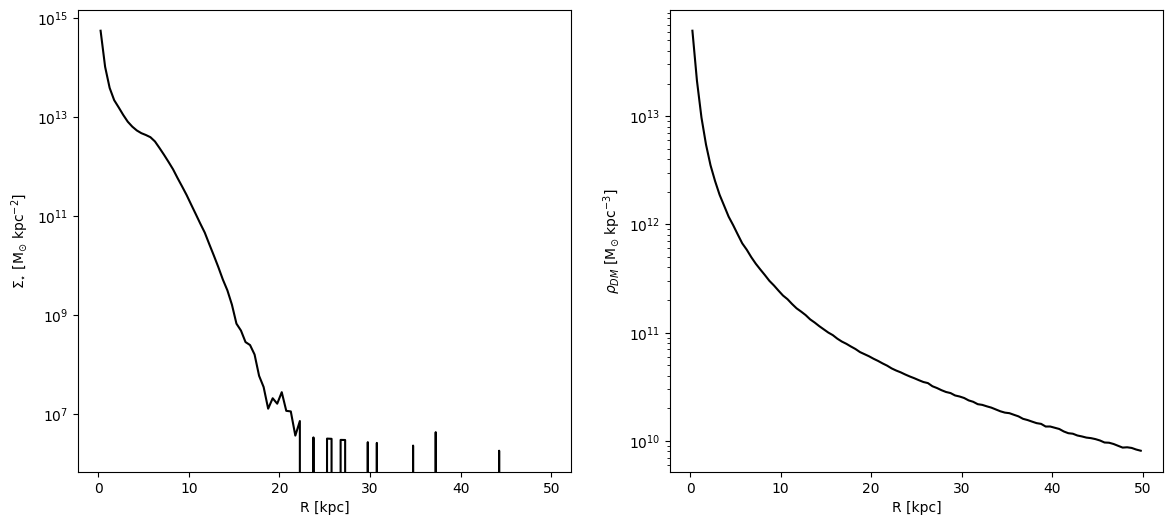

In [24]:
for s in s_lst:
    # center on the largest halo and align the disk
    pb.analysis.angmom.faceon(s)

    # convert all units to something reasonable (kpc, Msol etc)
    s.physical_units()

    # create a profile object for the stars (by default this is a 2D profile)
    p = pb.analysis.profile.Profile(s.star, vmin =.01, max=50)

    # Checking derivable keys
    p.derivable_keys()

    # make the figure and sub plots
    f, axs = plt.subplots(1,2,figsize=(14,6))

    # make the plot
    axs[0].plot(p['rbins'],p['density'], 'k')
    axs[0].semilogy()
    axs[0].set_xlabel('R [kpc]')
    axs[0].set_ylabel(r'$\Sigma_{\star}$ [M$_{\odot}$ kpc$^{-2}$]')

    # make a 3D density plot of the dark matter (note ndim=3 in the constructor below)
    p = pb.analysis.profile.Profile(s.dark,min=.01,max=50,ndim=3)

    axs[1].plot(p['rbins'],p['density'], 'k')
    axs[1].semilogy()
    axs[1].set_xlabel('R [kpc]')
    axs[1].set_ylabel(r'$\rho_{DM}$ [M$_{\odot}$ kpc$^{-3}$]')

## Rendering simple images with pynbody built-in functions

We render some simple images with pynbody image function, faceon, edgeon.

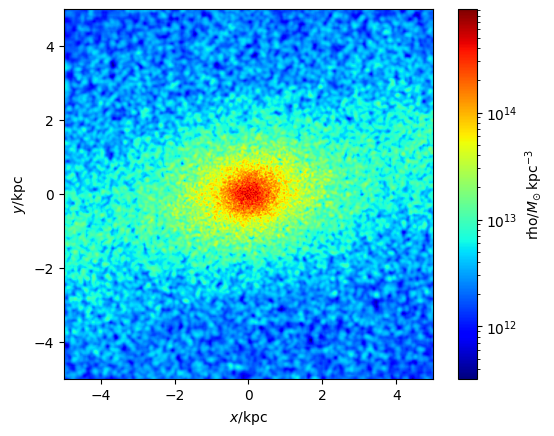

In [50]:
import pynbody.plot.sph as sph
cmap = 'jet'

# s = pbload(data_fname00200,param_fname)
for s in s_lst:
    pb.analysis.angmom.faceon(s)
    sph.image(s.star,qty="rho",width=10,cmap=cmap)

Rotate 70 degrees clockwise about Z axis.

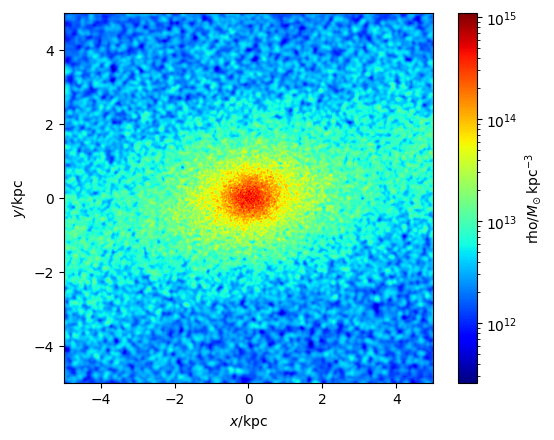

In [48]:
for s in s_lst:
    s.rotate_z(-170)
    sph.image(s.star,qty="rho",width=10,cmap=cmap)

Let us rotate 90 clockwise about X axis to get an edge-on view.

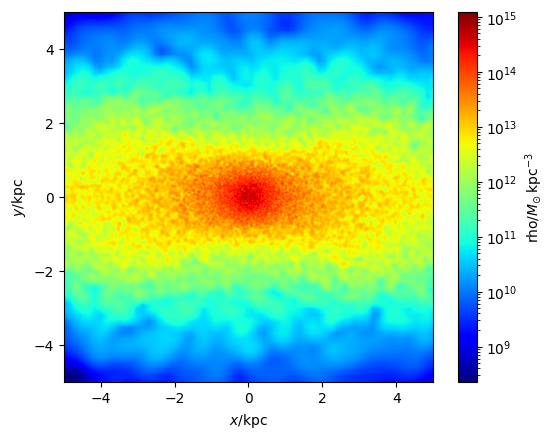

In [51]:
for s in s_lst:
    s.rotate_x(-90)
    sph.image(s.star,qty="rho",width=10,cmap=cmap)

## Binned 2d-statistics for number density and velocity

### Number density

#### Load data

In [2]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s_lst = load_data_lst()

Loading data from file /home/ubuntu/projects/S2B/models/new_models/run761AV.02000.gz ...
Done!


/home/ubuntu/.local/lib/python3.10/site-packages/pynbody/snapshot/tipsy.py:124: RuntimeWarning: No readable param file in the run directory or parent directory: using defaults.
  warnings.warn(


* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by 113.04864093639446 degrees*
Loading data from file /home/ubuntu/projects/S2B/models/new_models/run761BP.02000.gz ...
Done!
* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by 112.59277881250675 degrees*
Loading data from file /home/ubuntu/projects/S2B/models/new_models/run761CK.02400.gz ...
Done!
* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by -179.7484391903921 degrees*
Loading data from file /home/ubuntu/projects/S2B/models/new_models/run761CL.02400.gz ...
Done!
* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by -160.90383324344756 degrees*


In [53]:
# Define global variables

bins = 50
# xlim, ylim = 25, 25 #Full view kpc
cmap = 'jet'

#### Face-on number density

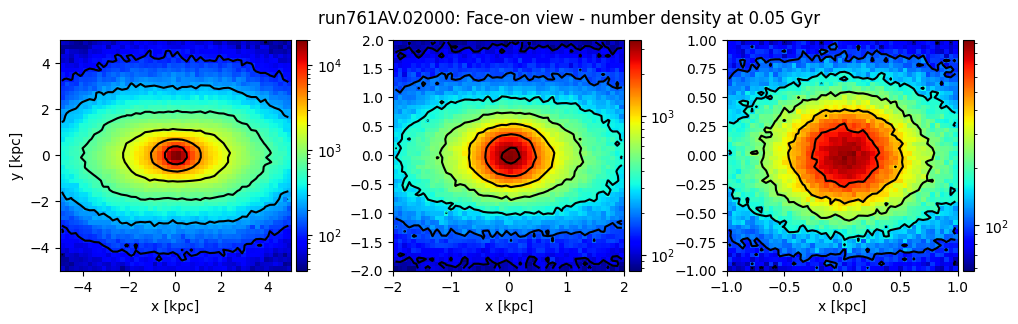

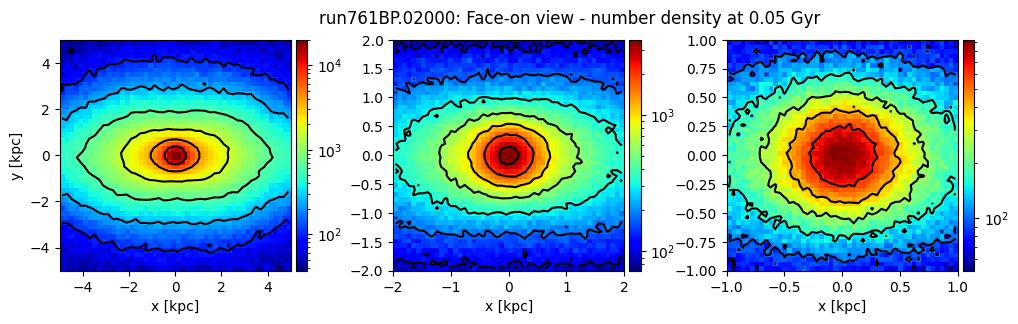

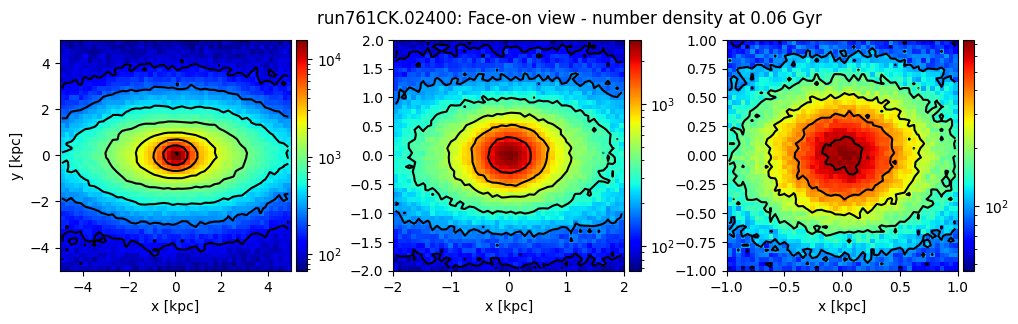

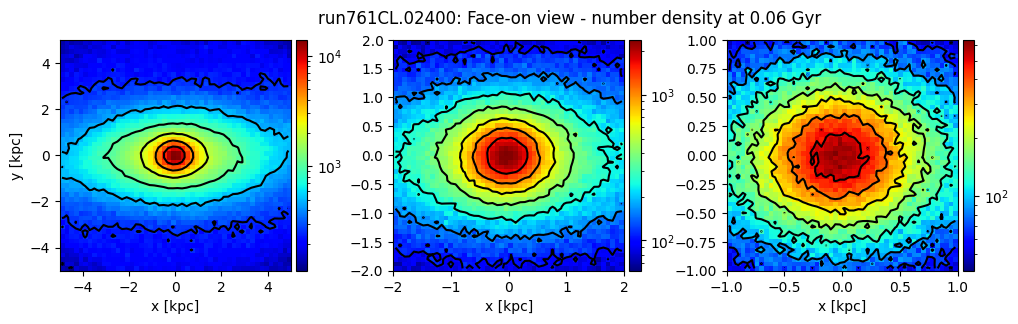

In [71]:
# Zoom in
xy_lim = [[5,5],[2,2],[1,1],[0.5,0.5]] #kpc
#xlim, ylim = 0.5, 0.5 #kpc
#xlim, ylim = 1, 1 #kpc
#xlim, ylim = 5, 5 #kpc
plt_title = 'Face-on view - number density'
cbar_label = 'Log10 number density'

j = 0
for s in s_lst:
    # make the figure and sub plots
    fig,axes = plt.subplots(1,4,figsize=(14,3))
    
    i = 0
    for lim in xy_lim:
        age = round(s.properties['time'].in_units('Gyr'),2)
        xlim, ylim = lim[0], lim[1]
    
        stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
    
        image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap=cmap)

        #axes[i].title.set_text(str(age) + ' Gyr')

        xcent = (xedges[1:] + xedges[:-1]) / 2
        ycent = (yedges[1:] + yedges[:-1]) / 2
        axes[i].contour(xcent, ycent, np.log10(stat2d.T), colors='k')
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(image, cax=cax, orientation='vertical')
    
        i = i + 1

    fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
    #cbar = fig.colorbar(image, cax = cbar_ax)
    #cbar.set_label(cbar_label)
    fig.suptitle(snap_lst[j].replace(".gz",": ") + plt_title + ' at ' + str(age) + ' Gyr')
    plt.setp(axes[:], xlabel='x [kpc]')
    plt.setp(axes[0], ylabel='y [kpc]')
    plt.savefig(image_dir + snap_lst[j].replace(".gz","") + '_face_on_num_dens' + '.png')
    plt.show()
    j = j + 1


#### Inclination 60 deg - number density

Rotate 60 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [18]:
for s in s_lst:
    s.rotate_x(-60)

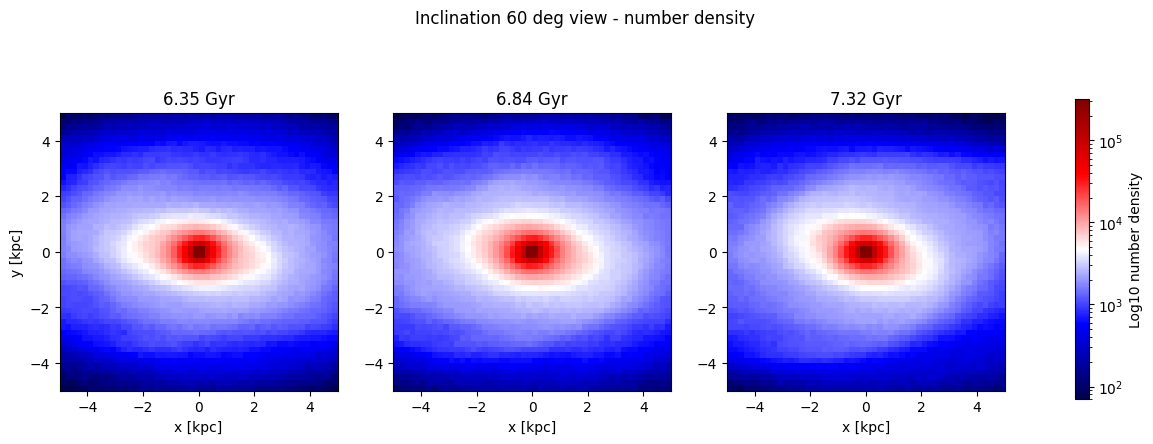

In [19]:
# Zoom in
xlim, ylim = 5, 5 #kpc
plt_title = 'Inclination 60 deg view - number density'
cbar_label = 'Log10 number density'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Edge-on - number density

Rotate 60 + 30 = 90 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [20]:
for s in s_lst:
    s.rotate_x(-30)

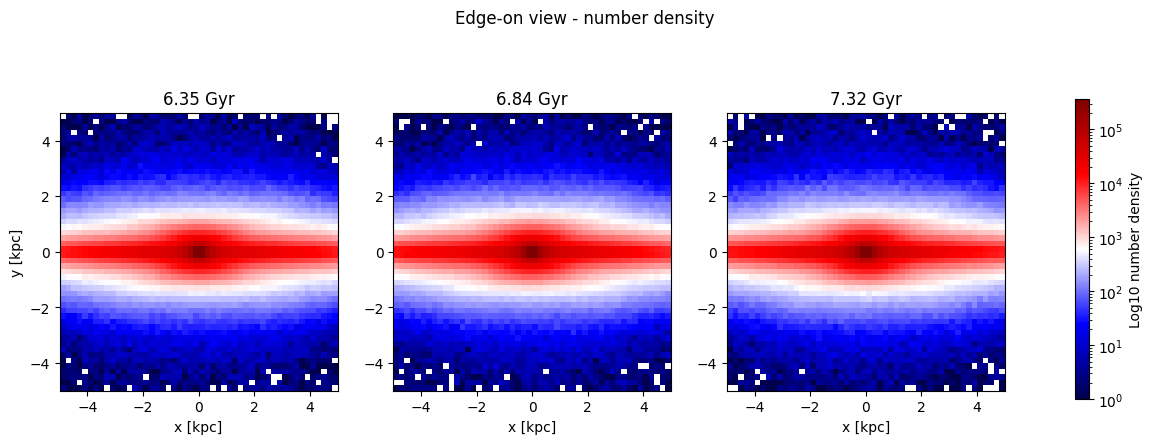

In [21]:
# Zoom in
xlim, ylim = 5, 5 #kpc
plt_title = 'Edge-on view - number density'
cbar_label = 'Log10 number density'

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

### Velocity distribution

#### Load data

In [85]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s_lst = load_data_lst()
for s in s_lst:
    pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.00100 ...
Done!
Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.00200 ...
Done!
Loading data from file /home/ubuntu/projects/S2B/shared/run739HF/run739HF.00300 ...
Done!


#### Basic velocity distribution histograms

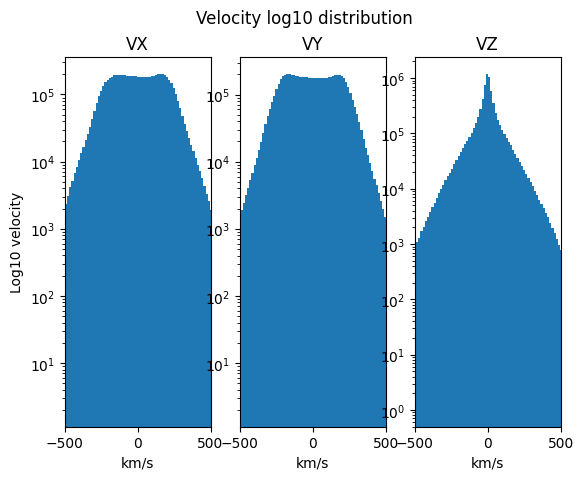

In [37]:

for s in s_lst:
# Extracting position and velocity components

    x = s.star['pos'][:,0]
    y = s.star['pos'][:,1]
    z = s.star['pos'][:,2]
    vx = s.star['vel'][:,0]
    vy = s.star['vel'][:,1]
    vz = s.star['vel'][:,2]

    x_lim = 500
    bins = 100

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Velocity log10 distribution')
    ax1.hist(vx, log = True, bins = bins)
    ax1.set_title('VX')
    ax1.set_xlim(-x_lim, x_lim)
    ax1.set_xlabel('km/s')
    ax1.set_ylabel('Log10 velocity')
    ax2.hist(vy, log = True, bins = bins)
    ax2.set_title('VY')
    ax2.set_xlim(-x_lim, x_lim)
    ax2.set_xlabel('km/s')
    ax3.hist(vz, log = True, bins = bins)
    ax3.set_title('VZ')
    ax3.set_xlim(-x_lim, x_lim)
    ax3.set_xlabel('km/s')
    
plt.show()

#### Face-on - mean velocity

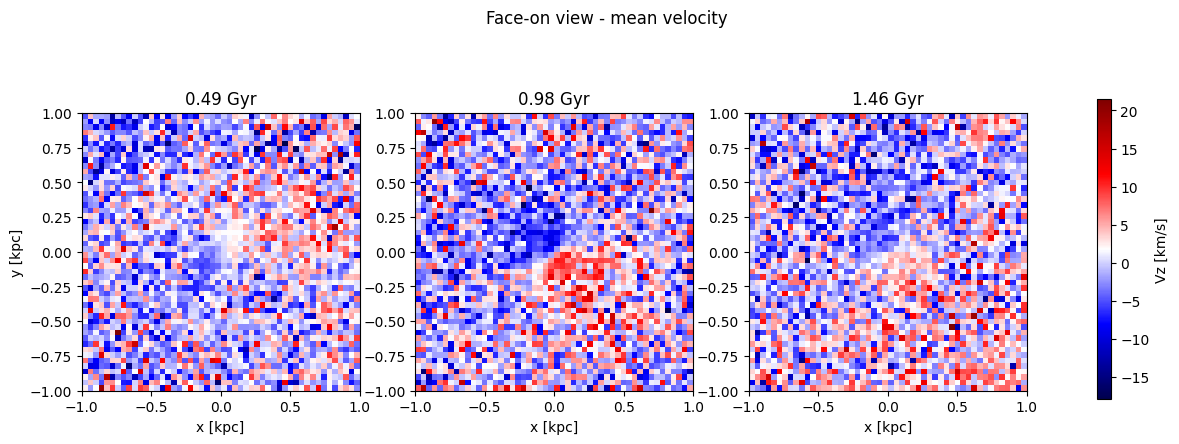

In [92]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Face-on view - mean velocity'
cbar_label = 'Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Face-on - velocity dispersion

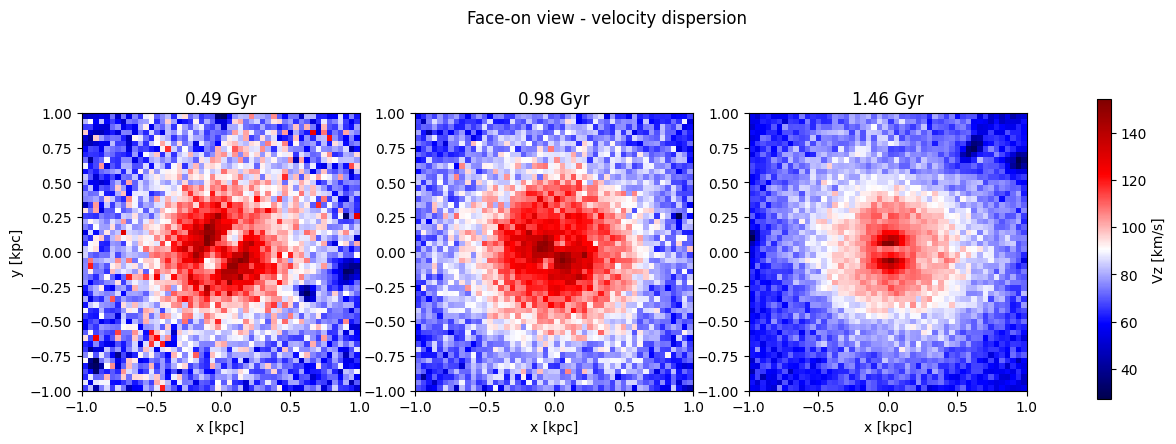

In [93]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Face-on view - velocity dispersion'
cbar_label = 'Sigma_Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Inclination 60 deg - mean velocity

In [94]:
for s in s_lst:
    s.rotate_x(-60)

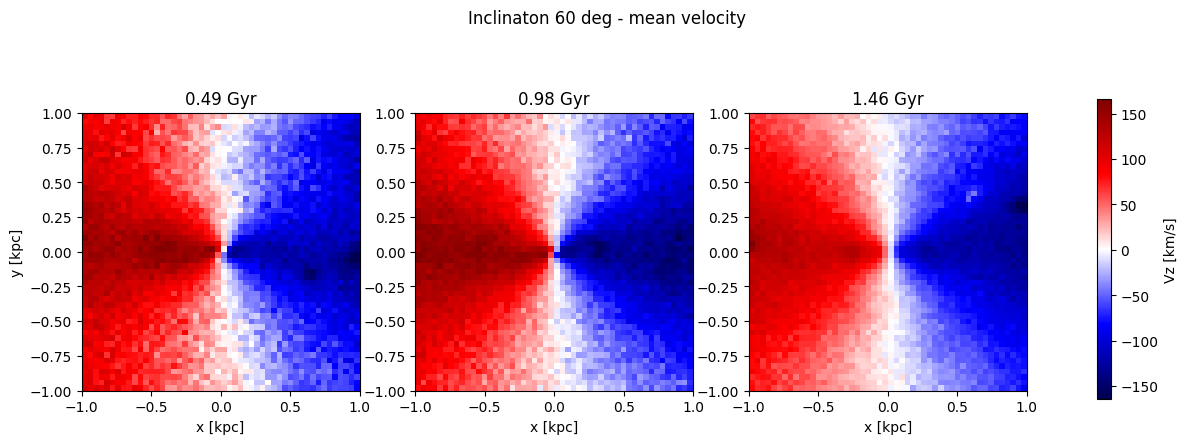

In [97]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Inclinaton 60 deg - mean velocity'
cbar_label = 'Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Inclination 60 deg - velocity dispersion

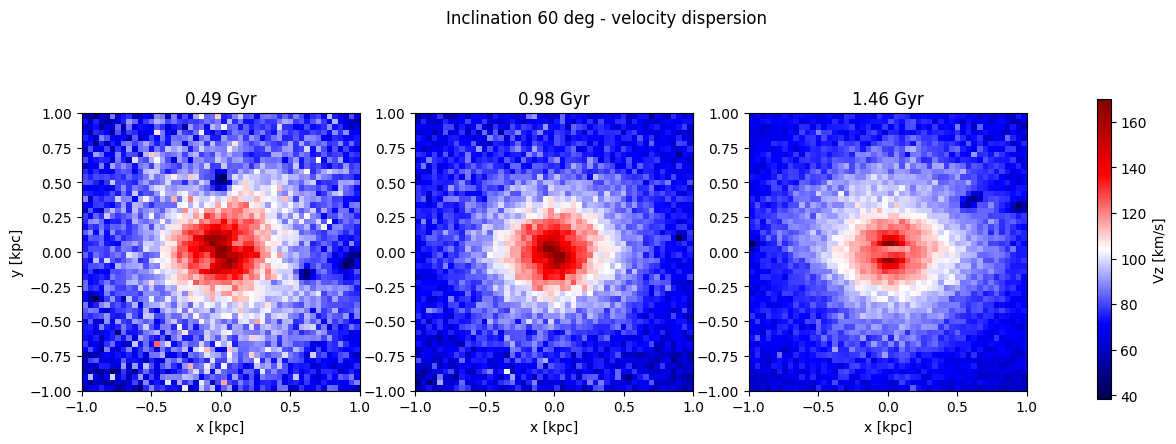

In [96]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Inclination 60 deg - velocity dispersion'
cbar_label = 'Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Edge-on - mean velocity

Rotate 90 degrees clockwise about X axis for edge-on view.
Calculate the binned velocity 2d statistics and plot.

In [98]:
for s in s_lst:
    s.rotate_x(-30)

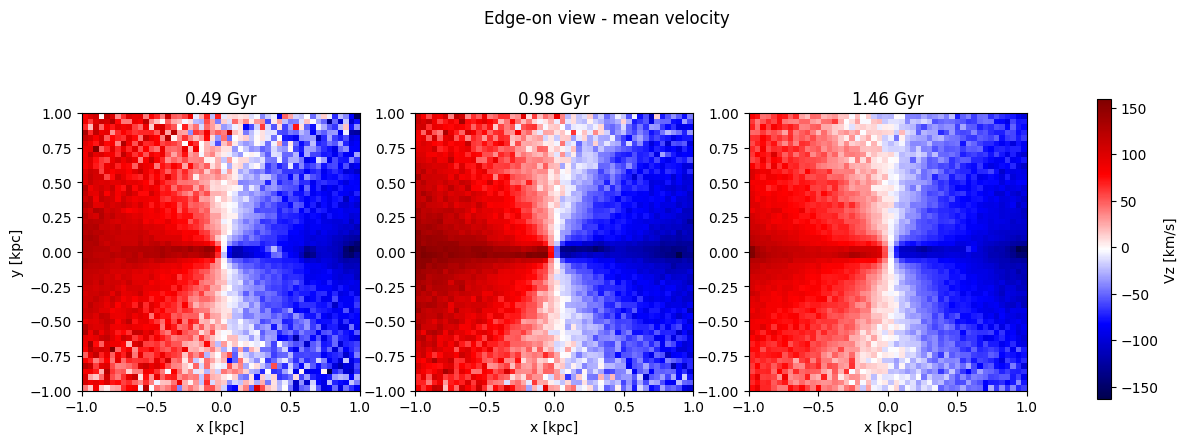

In [99]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Edge-on view - mean velocity'
cbar_label = 'Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()


#### Edge-on - velocity dispersion

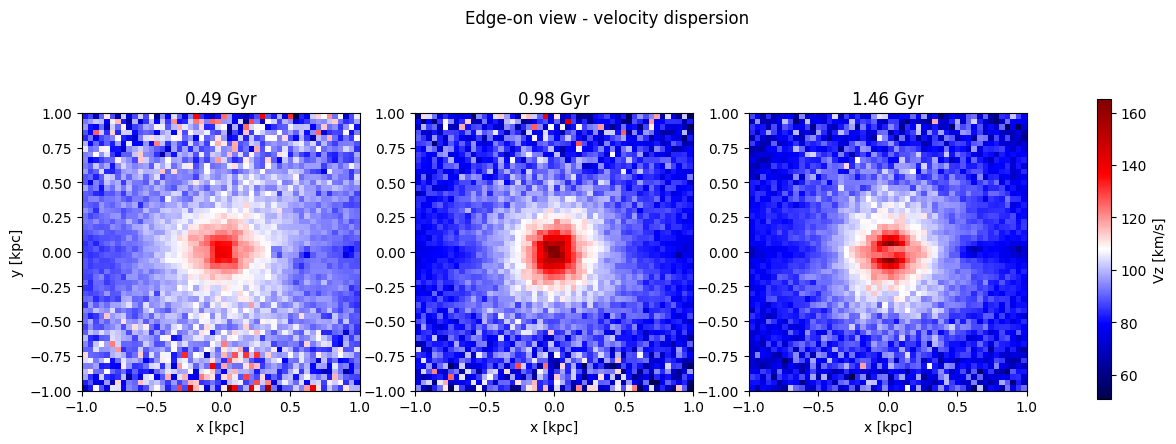

In [100]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Edge-on view - velocity dispersion'
cbar_label = 'Vz [km/s]'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()


#### Edge-on - h3

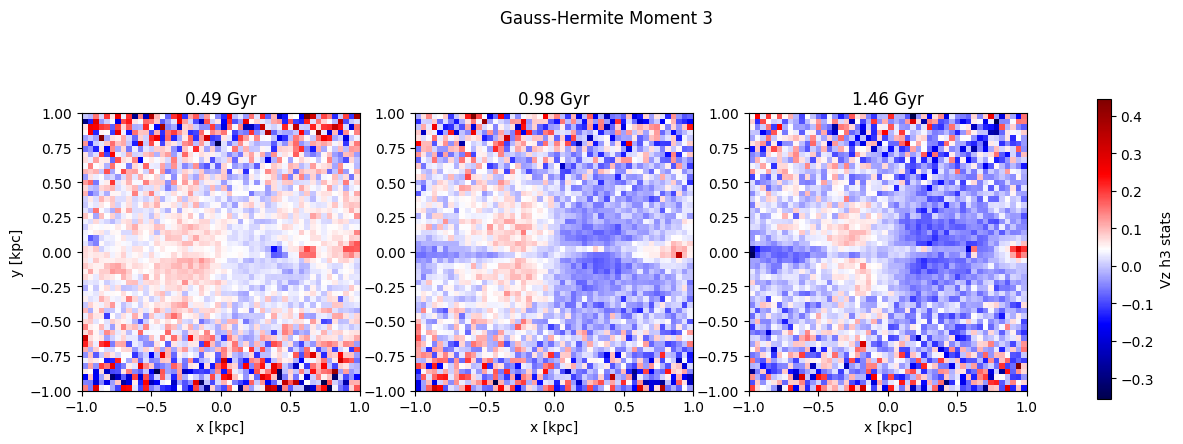

In [102]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Gauss-Hermite Moment 3'
cbar_label = 'Vz h3 stats'
m = 3

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()

#### Edge-on - h4

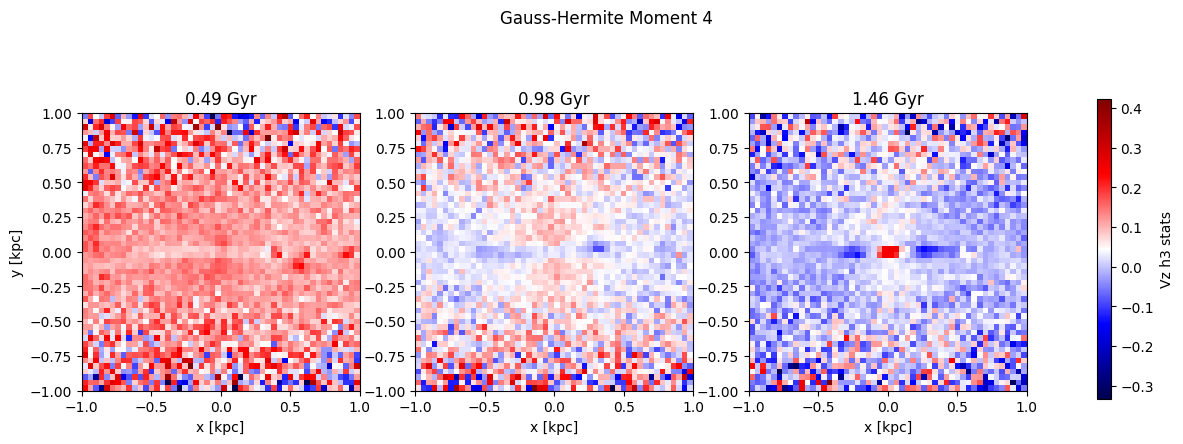

In [103]:
# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Gauss-Hermite Moment 4'
cbar_label = 'Vz h3 stats'
m = 4

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))

i = 0
for s in s_lst:
    age = round(s.properties['time'].in_units('Gyr'),2)
    
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap=cmap)

    axes[i].title.set_text(str(age) + ' Gyr')
    i = i + 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title)
plt.setp(axes[:], xlabel='x [kpc]')
plt.setp(axes[0], ylabel='y [kpc]')
plt.show()